# Tutorial 13 (JAX): Vector Quantization

In [1]:
## Standard libraries
import os
import math
import numpy as np
from typing import Sequence, Any
from collections import defaultdict

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()

## tqdm for loading bars
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# Import tensorboard
# %load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (i.e. STL10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial13_jax"

print("Device:", jax.devices()[0])

Device: gpu:0


In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial13/"
# Files to download
pretrained_files = []
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

### Data preparation

In [3]:
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - 0.5) * 2.0
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

train_transforms = transforms.Compose([
                                 transforms.Resize((64, 64)),
                                 transforms.RandomHorizontalFlip(),
                                 image_to_numpy
                                ])
test_transforms = transforms.Compose([
                                 transforms.Resize((64, 64)),
                                 image_to_numpy
                                ])

train_data = STL10(root=DATASET_PATH, split='unlabeled', download=True,
                   transform=train_transforms)
train_data_plain = STL10(root=DATASET_PATH, split='unlabeled', download=True,
                         transform=test_transforms)
test_data = STL10(root=DATASET_PATH, split='train', download=True,
                  transform=test_transforms)
test_data, val_data = data.random_split(test_data, [3000, 2000], 
                                        generator=torch.Generator().manual_seed(42))

train_loader = data.DataLoader(train_data,
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=0,
                               # persistent_workers=True,
                               generator=torch.Generator().manual_seed(42)
                              )
val_loader   = data.DataLoader(val_data,
                               batch_size=64,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=0,
                               # persistent_workers=True
                              )
test_loader  = data.DataLoader(test_data,
                               batch_size=64,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=0,
                               # persistent_workers=True
                              )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imgs_to_grid(imgs, pads=2, num_rows=4):
    imgs = np.pad(imgs, ((0,0), (pads,pads), (pads,pads), (0,0)))
    imgs = np.reshape(imgs, (num_rows, -1, *imgs.shape[1:]))
    imgs = imgs.swapaxes(1, 2)
    imgs = imgs.reshape(num_rows*imgs.shape[1], -1, imgs.shape[-1])
    imgs = np.pad(imgs, ((pads,pads), (pads,pads), (0,0)))
    imgs = (imgs + 1.) / 2.
    return imgs

def show_imgs(imgs, num_rows=4, title=''):
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(imgs_to_grid(imgs, num_rows=num_rows))
    plt.axis('off')
    plt.show()

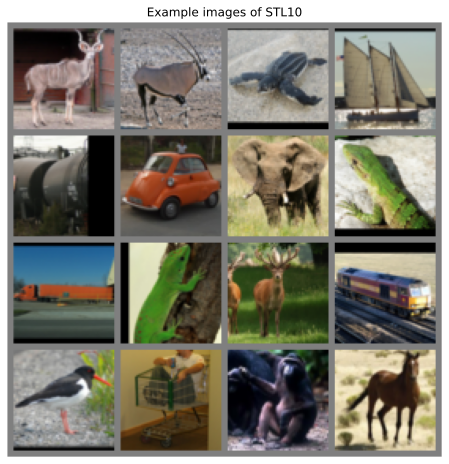

In [5]:
show_imgs(np.stack([train_data_plain[i][0] for i in range(16)], axis=0), 
          title='Example images of STL10')

## VQVAE model

In [6]:
class Norm(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        return nn.GroupNorm(num_groups=None, group_size=16, epsilon=1e-6)(x)

In [7]:
class ResNetBlock(nn.Module):
    act_fn: callable  # Activation function
    c_out: int   # Output feature size

    @nn.compact
    def __call__(self, x):
        # Network representing F
        z = Norm()(x)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3))(z)
        z = Norm()(z)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3))(z)

        if x.shape[-1] != z.shape[-1]:
            x = nn.Conv(self.c_out, kernel_size=(1, 1))(x)

        return x + z

In [8]:
class AttnBlock(nn.Module):

    @nn.compact
    def __call__(self, x):
        residual = x
        x = Norm()(x)
        
        qkv = nn.Conv(3*x.shape[-1], kernel_size=(1, 1))(x)
        query, key, value = qkv.split(3, axis=-1)

        # compute attentions
        B, H, W, C = query.shape
        query = query.reshape((B, H * W, C))
        key = key.reshape((B, H * W, C))
        attn_weights = jnp.einsum('...qc,...kc->...qk', query, key)
        attn_weights = attn_weights * (int(C) ** -0.5)
        attn_weights = nn.softmax(attn_weights, axis=-1)

        ## attend to values
        value = value.reshape((B, H * W, C))
        x = jnp.einsum('...kc,...qk->...qc', value, attn_weights)
        x = x.reshape((B, H, W, C))

        x = nn.Conv(x.shape[-1], kernel_size=(1, 1))(x)
        x = x + residual
        return x

### Encoder

In [9]:
class Encoder(nn.Module):
    num_blocks: Sequence[int]
    c_hidden: Sequence[int]
    vocab_dim: int
    act_fn: callable = nn.swish

    def setup(self):
        self.in_conv = nn.Conv(self.c_hidden[0], kernel_size=(3, 3))
        block_modules = []
        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):
                # Subsample the first block of each group, except the very first one.
                if (bc == 0 and block_idx > 0):
                    block_modules.append(
                        lambda inp: nn.avg_pool(inp, window_shape=(2, 2), strides=(2, 2))
                    )
                block_modules.append(
                    ResNetBlock(act_fn=self.act_fn,
                                c_out=self.c_hidden[block_idx])
                )
                if block_idx > 1 and bc < block_count - 1:
                    block_modules.append(AttnBlock())
        self.block_modules = block_modules

        self.out_norm = Norm()
        self.out_conv = nn.Conv(self.vocab_dim, kernel_size=(3, 3))

    def __call__(self, x):
        x = self.in_conv(x)
        for layer in self.block_modules:
            x = layer(x)
        x = self.out_norm(x)
        x = self.act_fn(x)
        x = self.out_conv(x)
        return x

In [10]:
module = Encoder(num_blocks=[2, 2, 3],
                 c_hidden=[64, 128, 256],
                 vocab_dim=256)
inp, _ = next(iter(train_loader))
variables = module.init(random.PRNGKey(0), inp)
# params, batch_stats = variables['params'], variables['batch_stats']
out = module.apply(variables, inp)
vecs = out
print(vecs.shape)
print(vecs.reshape(-1, vecs.shape[-1]).std(axis=0).mean())

(64, 16, 16, 256)
0.45162132


### Decoder

In [11]:
class Upsample(nn.Module):
    scale_factor : float = 2.0
    method : str = 'bilinear'
    
    @nn.compact
    def __call__(self, x):
        B, H, W, C = x.shape
        x = jax.image.resize(x, 
                             shape=(B, int(H * self.scale_factor), int(W * self.scale_factor), C),
                             method=self.method)
        return x

In [12]:
class Decoder(nn.Module):
    num_blocks: Sequence[int]
    c_hidden: Sequence[int]
    c_out: int
    act_fn: callable = nn.swish

    def setup(self):
        self.in_conv = nn.Conv(self.c_hidden[0], kernel_size=(1, 1))

        block_modules = []
        for block_idx, block_count in enumerate(self.num_blocks):
            if block_idx > 0:
                block_modules.append(Upsample())
            for bc in range(block_count):
                channel_change = (bc == 0 and block_idx > 0)
                block_modules.append(
                    ResNetBlock(act_fn=self.act_fn,
                                c_out=self.c_hidden[block_idx])
                )
                if block_idx == 0 and bc < block_count - 1:
                    block_modules.append(AttnBlock())

        self.block_modules = block_modules
        self.out_norm = Norm()
        self.out_conv = nn.Conv(self.c_out, kernel_size=(3, 3))

    def __call__(self, x):
        x = self.in_conv(x)
        for layer in self.block_modules:
            x = layer(x)
        x = self.out_norm(x)
        x = self.act_fn(x)
        x = self.out_conv(x)
        x = nn.tanh(x)
        return x

In [13]:
module = Decoder(num_blocks=[3, 2, 2],
                 c_hidden=[256, 128, 64],
                 c_out=3)
inp = random.normal(random.PRNGKey(0), (64, 16, 16, 256))
variables = module.init(random.PRNGKey(0), inp)
out = module.apply(variables, inp)
print(out.shape)

(64, 64, 64, 3)


### Vector Quantization

In [14]:
class VQEmbedding(nn.Module):
    vocab_size : int
    vocab_dim : int
    
    def setup(self):
        self.codebook = nn.Embed(self.vocab_size, self.vocab_dim)
        
    def __call__(self, z):
        z_flatten = z.reshape(-1, z.shape[-1])
        
        # dummy op to init the weights, so we can access them below
        self.codebook(jnp.ones((1, 1), dtype="i4"))

        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z
        embed_weights = self.variables["params"]["codebook"]["embedding"]
        distance = (
            jnp.sum(z_flatten ** 2, axis=1, keepdims=True)
            + jnp.sum(embed_weights ** 2, axis=1)
            - 2 * jnp.dot(z_flatten, embed_weights.T)
        )

        # get quantized latent vectors
        embed_idxs = jnp.argmin(distance, axis=1)
        z_embeds = self.codebook(embed_idxs).reshape(z.shape)
        embed_idxs = embed_idxs.reshape(z.shape[:-1])
        z_q = z + jax.lax.stop_gradient(z_embeds - z)
        
        return z_q, z_embeds, embed_idxs
    
    def embed(self, embed_idxs):
        return self.codebook(embed_idxs)

In [15]:
module = VQEmbedding(vocab_size=512, vocab_dim=128)
inp = random.normal(random.PRNGKey(0), (64, 16, 16, 128))
params = module.init(random.PRNGKey(0), inp)
z_q, z_embeds, embed_idxs = module.apply(params, inp)
# z_q.shape
print(z_q.reshape(-1, vecs.shape[-1]).std(axis=0).mean())

0.09014279


### VQVAE model

In [16]:
def mse_loss(pred, target):
    return ((pred - jax.lax.stop_gradient(target))**2).mean()


class VQVAE(nn.Module):
    vocab_size : int
    vocab_dim : int
    beta : float
    resnet_blocks : Sequence[int] = (1, 2, 2)
    resnet_hidden : Sequence[int] = (32, 64, 128)
    
    def setup(self):
        # Encoder network (ResNet)
        self.encoder = Encoder(num_blocks=self.resnet_blocks,
                               c_hidden=self.resnet_hidden,
                               vocab_dim=self.vocab_dim,
                               act_fn=nn.swish)
        # Vector quantized bottleneck layer
        self.vector_quantization = VQEmbedding(vocab_size=self.vocab_size,
                                               vocab_dim=self.vocab_dim)
        # Decoder network (ResNet, mirrored version of Encoder)
        self.decoder = Decoder(num_blocks=self.resnet_blocks[::-1],
                               c_hidden=self.resnet_hidden[::-1],
                               c_out=3,
                               act_fn=nn.swish)
        
    def __call__(self, x):
        z = self.encoder(x)
        z_quantized, z_embeddings, _ = self.vector_quantization(z)
        x_rec = self.decoder(z_quantized)
        
        rec_loss = mse_loss(x_rec, x)
        embed_loss = mse_loss(z_embeddings, z)
        quant_loss = mse_loss(z, z_embeddings)
        
        loss = rec_loss + embed_loss + self.beta * quant_loss
        
        metrics = {'loss': loss,
                   'rec_loss': rec_loss,
                   'l1_dist': jnp.abs(x_rec - x).mean(),
                   'embed_loss': embed_loss,
                   'quant_loss': self.beta * quant_loss}
        
        return loss, metrics
        
    def reconstruct(self, x):
        z = self.encoder(x)
        z, _, _ = self.vector_quantization(z)
        x_rec = self.decoder(z)
        return x_rec
    
    def encode(self, x):
        z = self.encoder(x)
        _, _, embed_idxs = self.vector_quantization(z)
        return embed_idxs
    
    def decode(self, embed_idxs):
        z = self.vector_quantization.embed(embed_idxs)
        x_rec = self.decoder(z)
        return x_rec

### Trainer module

In [17]:
class TrainState(train_state.TrainState):
    # A simple extension of TrainState to also include an PRNG key
    # Useful for later
    rng: Any

In [18]:
class TrainerModule:

    def __init__(self, exmp_imgs, lr=5e-4, seed=42, **model_hparams):
        """
        Module for summarizing all training functionalities for classification on CIFAR10.

        Inputs:
            exmp_imgs - Example imgs, used as input to initialize the model
            lr - Learning rate of the optimizer to use
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.lr = lr
        self.seed = seed
        self.exmp_imgs = exmp_imgs
        # Create empty model. Note: no parameters yet
        self.create_model(model_hparams)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, f'{self.model_name}/')
        self.logger = SummaryWriter(log_dir=self.log_dir)
        self.logged_orig_imgs = False
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)
        
    def create_model(self, model_hparams):
        self.model_name = 'VQVAE'
        self.model = VQVAE(**model_hparams)
        self.eval_metric_key = 'rec_loss'

    def create_functions(self):
        # Training function
        def train_step(state, batch):
            imgs, _ = batch
            loss_fn = lambda params: self.model.apply(params, imgs)
            (_, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            state = state.apply_gradients(grads=grads)
            return state, metrics
        # Eval function
        def eval_step(state, batch):
            imgs, _ = batch
            _, metrics = self.model.apply(state.params, imgs)
            return metrics
        # Reconstruction function
        def reconst_func(state):
            x_rec = self.model.bind(state.params).reconstruct(self.exmp_imgs[:16])
            return jax.device_get(x_rec)
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)
        self.reconst_func = jax.jit(reconst_func)

    def init_model(self, exmp_imgs):
        # Initialize model
        rng = random.PRNGKey(self.seed)
        rng, init_rng = random.split(rng)
        params = self.model.init(init_rng, exmp_imgs)
        self.state = TrainState(step=0,
                                apply_fn=self.model.apply,
                                params=params,
                                rng=rng,
                                tx=None, opt_state=None)

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # We decrease the learning rate by a factor of 0.1 after 60% and 85% of the training
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=50,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=1e-2*self.lr
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.state.apply_fn,
                                       params=self.state.params,
                                       rng=self.state.rng,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval reconstruction
        best_eval = 1e6
        self.log_reconstructions(0)
        print('Training starts')
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(data_loader=train_loader, epoch=epoch_idx)
            if epoch_idx % 1 == 0:
                eval_metrics = self.eval_model(val_loader)
                print(f'[Epoch {epoch_idx}]', ', '.join([f'{key}: {eval_metrics[key]:5.4f}' for key in eval_metrics]))
                for key in eval_metrics:
                    self.logger.add_scalar(f'val/{key}', eval_metrics[key], global_step=epoch_idx)
                if eval_metrics[self.eval_metric_key] <= best_eval:
                    best_eval = eval_metrics[self.eval_metric_key]
                    self.save_model(step=epoch_idx)
            if epoch_idx % 10 == 0:
                self.log_reconstructions(epoch_idx)
            self.logger.flush()

    def train_epoch(self, data_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(float)
        for batch in tqdm(data_loader, desc='Training', leave=False):
            self.state, batch_metrics = self.train_step(self.state, batch)
            for key in batch_metrics:
                metrics[key] += batch_metrics[key]
        num_train_steps = len(data_loader)
        for key in metrics:
            avg_val = metrics[key].item() / num_train_steps
            self.logger.add_scalar(f'train/{key}', avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        count = 0
        metrics = defaultdict(float)
        for batch in data_loader:
            batch_metrics = self.eval_step(self.state, batch)
            batch_size = batch[0].shape[0] if isinstance(batch, (list, tuple)) else batch.shape[0]
            count += batch_size
            for key in batch_metrics:
                metrics[key] += batch_metrics[key] * batch_size
        metrics = {key: metrics[key].item() / count for key in metrics}
        return metrics
    
    def log_reconstructions(self, epoch_idx):
        x_rec = self.reconst_func(self.state)
        self.logger.add_image('reconstructions', imgs_to_grid(x_rec), global_step=epoch_idx, dataformats='HWC')
        
        if not self.logged_orig_imgs:
            x_ori = imgs_to_grid(self.exmp_imgs[:x_rec.shape[0]])
            self.logger.add_image('originals', x_ori, global_step=epoch_idx, dataformats='HWC')
            self.logged_orig_imgs = True
        
    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target=self.state.params,
                                    step=step,
                                    overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=None)
        if 'batch_stats' in state_dict:
            state_dict.pop('batch_stats')
        self.state = TrainState.create(apply_fn=self.state.apply_fn,
                                       params=state_dict,
                                       rng=self.state.rng,
                                       tx=self.state.tx if self.state.tx else optax.sgd(0.1)   # Default optimizer
                                      )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [19]:
def train_vqvae(*args, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    trainer.model_bd = trainer.model.bind(trainer.state.params)
    return trainer, {'val': val_acc, 'test': test_acc}

In [20]:
trainer, results = train_vqvae(vocab_size=512,
                               vocab_dim=64,
                               beta=0.25,
                               exmp_imgs=next(iter(train_loader))[0])

In [21]:
print(f'Validation reconstruction L2: {results["val"]["rec_loss"]:5.4f}, L1: {results["val"]["l1_dist"]:5.4f}')
print(f'Test reconstruction L2: {results["test"]["rec_loss"]:5.4f}, L1: {results["test"]["l1_dist"]:5.4f}')

Validation reconstruction L2: 0.0061, L1: 0.0522
Test reconstruction L2: 0.0062, L1: 0.0528


0.058863223


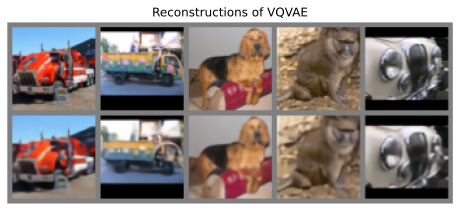

In [22]:
imgs, _ = next(iter(val_loader))
imgs = imgs[0:5]
x_rec = trainer.model_bd.reconstruct(imgs)
print((jnp.abs(x_rec - imgs)).mean())
img_stack = np.stack([imgs, x_rec], axis=0).reshape(-1, *imgs.shape[1:])
show_imgs(img_stack, num_rows=2, title='Reconstructions of VQVAE')

## Analyzing the VQVAE

- Overall distribution
- Check specific codes and highlight in an image where this code is used
- New combinations of codes => does this make any sense?

In [23]:
@jax.jit
def encode_imgs(imgs):
    return trainer.model_bd.encode(imgs)

def encode_dataset(dataset):
    encodings = []
    data_loader = data.DataLoader(dataset,
                                  batch_size=128,
                                  shuffle=False,
                                  drop_last=False,
                                  collate_fn=numpy_collate,
                                  num_workers=0)
    for imgs, _ in tqdm(data_loader, leave=False):
        embeds = encode_imgs(imgs)
        encodings.append(embeds)
    encodings = np.concatenate(encodings, axis=0)
    return encodings

train_encodings = encode_dataset(train_data_plain)
val_encodings   = encode_dataset(val_data)
test_encodings  = encode_dataset(test_data)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

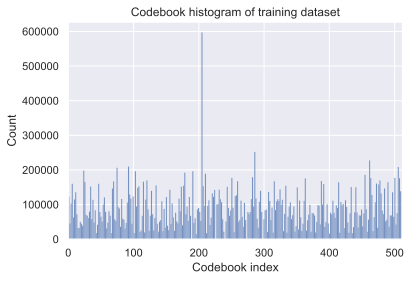

In [25]:
sns.set()
sns.histplot(train_encodings.reshape(-1))
plt.title('Codebook histogram of training dataset')
plt.xlabel('Codebook index')
plt.xlim([0, trainer.model.vocab_size])
plt.show()

In [26]:
hist = np.histogram(train_encodings.reshape(-1), bins=trainer.model.vocab_size, range=(0,trainer.model.vocab_size))[0]
print(f'Codebook usage: {(hist != 0).sum()/hist.shape[0]:4.2%}')

Codebook usage: 95.31%


### Code analysis

In [27]:
hist_argsort = np.argsort(hist)
most_used_idx = hist_argsort[-1]
print(f'Most used code: {most_used_idx}')

Most used code: 205


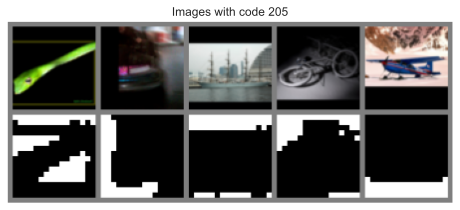

In [28]:
def show_imgs_of_code(code_idx, dataset, encodings, num_imgs=5):
    img_idx, _, _ = np.where(encodings == code_idx)
    if img_idx.shape[0] == 0:
        print('No images found...')
        return
    img_idx = np.argsort(-np.histogram(img_idx, bins=trainer.model.vocab_size, range=(0, trainer.model.vocab_size))[0])
    imgs = np.stack([dataset[img_idx[i]][0] for i in range(num_imgs)], axis=0)
    mask = (encodings[img_idx[:num_imgs]] == code_idx) * 2 - 1
    mask = np.repeat(mask, 4, axis=1)
    mask = np.repeat(mask, 4, axis=2)
    mask = np.repeat(mask[...,None], 3, axis=3)
    imgs = np.stack([imgs, mask], axis=0).reshape(-1, *imgs.shape[1:])
    show_imgs(imgs, num_rows=2, title=f'Images with code {code_idx}')
    
show_imgs_of_code(most_used_idx, train_data_plain, train_encodings)

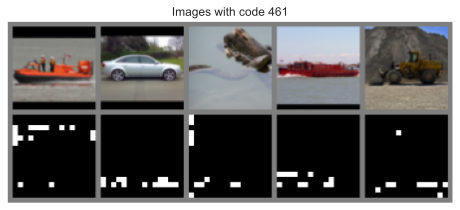

In [29]:
show_imgs_of_code(hist_argsort[-6], train_data_plain, train_encodings)

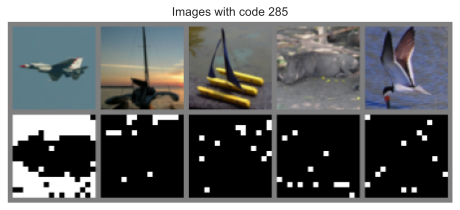

In [30]:
show_imgs_of_code(hist_argsort[-10], train_data_plain, train_encodings)

### Image manipulations

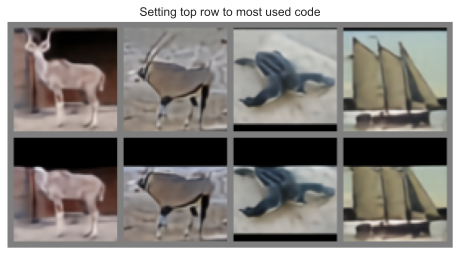

In [31]:
exmp_encodings = np.copy(train_encodings[:4])
imgs_rec = trainer.model_bd.decode(exmp_encodings)

exmp_encodings[:,:4,:] = most_used_idx
imgs_most = trainer.model_bd.decode(exmp_encodings)

imgs = np.stack([imgs_rec, imgs_most], axis=0).reshape(-1, *imgs_rec.shape[1:])
show_imgs(imgs, num_rows=2, title='Setting top row to most used code')

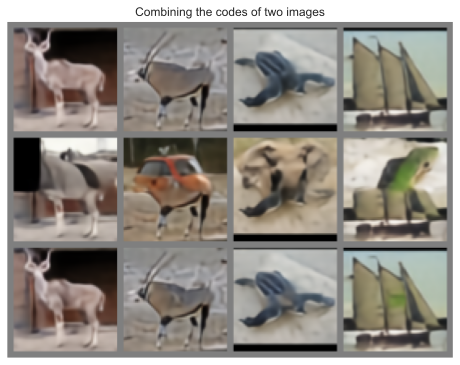

In [32]:
exmp_encodings = np.copy(train_encodings[:4])
exmp_encodings[:,:8,:] = train_encodings[4:8,:8,:]
imgs_rand = trainer.model_bd.decode(exmp_encodings)

exmp_encodings = np.copy(train_encodings[:4])
exmp_encodings[:,7:9,7:9] = train_encodings[4:8,7:9,7:9]
imgs_rand2 = trainer.model_bd.decode(exmp_encodings)

imgs = np.stack([imgs_rec, imgs_rand, imgs_rand2], axis=0).reshape(-1, *imgs_rec.shape[1:])
show_imgs(imgs, num_rows=3, title='Combining the codes of two images')

- VQVAE focuses on local changes => not really suited for full generative model
- local noise can be recovered => see changing center codes

## Generative modeling with VQVAE

- Random uniform sampling of codes
- TODO: Train Transformer on codespace of VQVAE

### Marginal distribution

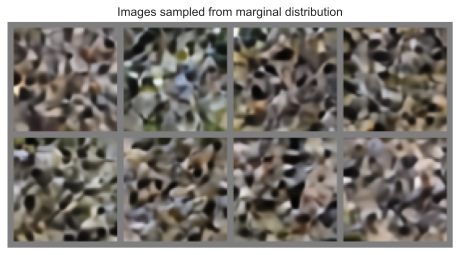

In [33]:
code_dist = hist / hist.sum()
rand_codes = np.random.default_rng(42).choice(code_dist.shape[0], p=code_dist, size=(8, 16, 16))
imgs_sampled = trainer.model_bd.decode(rand_codes)
show_imgs(imgs_sampled, num_rows=2, title='Images sampled from marginal distribution')

### Autoregressive modeling

In [34]:
class ARAttentionBlock(nn.Module):
    mlp_dim : int
    num_heads : int
    dropout_rate : float = 0.0
        
    @nn.compact
    def __call__(self, x, train=True):
        dp_module = nn.Dropout(self.dropout_rate, deterministic=not train)
        inp_x = nn.LayerNorm()(x)
        attn_mask = nn.make_causal_mask(x[...,0])
        attn_module = nn.SelfAttention(self.num_heads)
        attn_out = attn_module(x, mask=attn_mask)
        x = x + dp_module(attn_out)
        
        mlp_x = nn.Sequential([
            nn.LayerNorm(),
            nn.Dense(self.mlp_dim),
            nn.gelu,
            dp_module,
            nn.Dense(x.shape[-1])
        ])(x)
        x = x + dp_module(mlp_x)
        return x

In [35]:
class AutoregressiveTransformer(nn.Module):
    seq_length : int
    vocab_size : int
    num_layers : int = 4
    hidden_dim : int = 256
    num_heads : int = 8
    dropout_rate : float = 0.0
    
    def setup(self):
        self.token_embeddings = nn.Embed(self.vocab_size, self.hidden_dim,
                                         # embedding_init=nn.initializers.normal(stddev=1.0)
                                        )
        self.start_token = self.param('start_token',
                                      # nn.initializers.normal(stddev=1.0),
                                      nn.initializers.lecun_normal(),
                                      (1, self.hidden_dim),
                                      jnp.float32)
        self.position_embeddings = self.param('position_embeds',
                                              nn.initializers.lecun_normal(),
                                              (self.seq_length, self.hidden_dim),
                                              jnp.float32)
        self.attention_layers = [ARAttentionBlock(mlp_dim=2*self.hidden_dim,
                                                  num_heads=self.num_heads,
                                                  dropout_rate=self.dropout_rate) for _ in range(self.num_layers)]
        self.mlp_head = nn.Sequential([
            nn.LayerNorm(),
            nn.Dense(self.vocab_size)
        ])
        
    def __call__(self, x, train=True):
        feats = self.token_embeddings(x[:,:self.seq_length-1])
        start_feats = jnp.repeat(self.start_token[None], x.shape[0], axis=0)
        feats = jnp.concatenate([start_feats, feats], axis=1)
        feats += self.position_embeddings[None, :x.shape[1]]
        
        for layer in self.attention_layers:
            feats = layer(feats, train=train)
        
        logits = self.mlp_head(feats)
        
        x_onehot = jax.nn.one_hot(x, num_classes=logits.shape[-1])
        nll = optax.softmax_cross_entropy(logits, x_onehot).mean()
        bpd = nll.mean() * np.log2(np.exp(1))
        
        return bpd, logits
    
    def sample(self, rng, batch_size):
        x = jnp.zeros((batch_size, self.seq_length), dtype=jnp.int32)
        forward_func = jax.jit(lambda inp: self(inp, train=False)[1])
        
        for i in tqdm(range(self.seq_length), leave=False):
            logits = forward_func(x)[:,i]
            rng, tok_rng = random.split(rng)
            x = x.at[:,i].set(random.categorical(tok_rng, logits, axis=-1))
        
        return x

In [36]:
module = AutoregressiveTransformer(seq_length=256,
                                   num_layers=4,
                                   vocab_size=512,
                                   hidden_dim=256,
                                   num_heads=8,
                                   dropout_rate=0.25)
inp = random.randint(random.PRNGKey(0), minval=0, maxval=512, shape=(16, 256))
params = module.init({'params': random.PRNGKey(0), 'dropout': random.PRNGKey(42)}, inp, train=True)
bpd, logits = module.apply(params, inp, train=True, rngs={'dropout': random.PRNGKey(42)})
print(bpd.shape, logits.shape, bpd)

model_bd = module.bind(params)
model_bd.sample(rng=random.PRNGKey(0), batch_size=8)

() (16, 256, 512) 9.675664


  0%|          | 0/256 [00:00<?, ?it/s]

DeviceArray([[424, 174, 446, ..., 348, 409, 450],
             [ 50, 498, 474, ..., 234,  38,  59],
             [401,  15,  46, ...,  87, 506, 160],
             ...,
             [274, 448, 362, ..., 466, 210, 254],
             [492,  84, 186, ..., 304, 390,  47],
             [267, 448,  17, ..., 119, 245, 485]], dtype=int32)

In [37]:
class ARTrainerModule(TrainerModule):
    
    def create_model(self, model_hparams):
        self.model_name = 'AutoregressiveTransformer'
        self.model = AutoregressiveTransformer(**model_hparams)
        self.eval_metric_key = 'bpd'
        
    def create_functions(self):
        # Training function
        def train_step(state, batch):
            rng, dropout_rng = random.split(state.rng)
            loss_fn = lambda params: self.model.apply(params, batch, 
                                                      train=True,
                                                      rngs={'dropout': dropout_rng})[0]
            # Get loss, gradients for loss, and other outputs of loss function
            bpd, grads = jax.value_and_grad(loss_fn)(state.params)
            # Update parameters and batch statistics
            state = state.apply_gradients(grads=grads, rng=rng)
            return state, {'bpd': bpd}
        # Eval function
        def eval_step(state, batch):
            # Return the accuracy for a single batch
            bpd, _ = self.model.apply(state.params, batch, train=False)
            return {'bpd': bpd}
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        rng = random.PRNGKey(self.seed)
        rng, params_rng, dropout_rng = random.split(rng, 3)
        params = self.model.init({'params': params_rng, 'dropout': dropout_rng}, 
                                 exmp_imgs, 
                                 train=True)
        self.state = TrainState(step=0,
                                apply_fn=self.model.apply,
                                params=params,
                                rng=rng,
                                tx=None, opt_state=None)
        
    def log_reconstructions(self, epoch_idx):
        pass

In [38]:
def get_code_data_loader(encodings, is_train=True):
    return data.DataLoader(encodings.reshape(encodings.shape[0], -1),
                           batch_size=128,
                           shuffle=is_train,
                           drop_last=is_train,
                           collate_fn=numpy_collate,
                           num_workers=0,
                           generator=torch.Generator().manual_seed(42))

code_train_loader = get_code_data_loader(train_encodings, is_train=True)
code_val_loader   = get_code_data_loader(val_encodings, is_train=False)
code_test_loader  = get_code_data_loader(test_encodings, is_train=False)

In [39]:
def train_transformer(*args, num_epochs=100, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = ARTrainerModule(*args, **kwargs)
    
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(code_train_loader, code_val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    # Test trained model
    val_acc = trainer.eval_model(code_val_loader)
    test_acc = trainer.eval_model(code_test_loader)
    trainer.model_bd = trainer.model.bind(trainer.state.params)
    return trainer, {'val': val_acc, 'test': test_acc}

In [40]:
trainer_transformer, results = train_transformer(vocab_size=trainer.model.vocab_size,
                                                 seq_length=train_encodings.shape[1] * train_encodings.shape[2],
                                                 exmp_imgs=next(iter(code_train_loader)),
                                                 num_epochs=100,
                                                 dropout_rate=0.1)

Training starts


  0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/781 [00:00<?, ?it/s]

[Epoch 1] bpd: 7.2656


Training:   0%|          | 0/781 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Sampling with autoregressive prior

In [41]:
code_sample = trainer_transformer.model_bd.sample(random.PRNGKey(42), 16)
code_sample = code_sample.reshape(-1, *train_encodings.shape[1:])
img_sample = trainer.model_bd.decode(code_sample)
show_imgs(img_sample, num_rows=4, title='Image samples from autoregressive prior')

NameError: name 'trainer_transformer' is not defined